In [0]:
!pip install dgl
!pip install networkx
import torch as th
from torch import nn
import torch.nn.functional as F
from torch.nn import init
import dgl.function as fn 
from dgl.base import DGLError

In [0]:
import torch
import dgl

## The graph classifier will be built out of two graph-convolution layers

## The graph convolution  : <br>   $h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ij}}h_j^{(l)}W^{(l)})$ <br> with $c_{ij} = \sqrt{|\mathcal{N}(i)|}\sqrt{|\mathcal{N}(j)|}$ ; <br> $H^{(l+1)} = \sigma ( \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} W^{l} ) $

In [0]:
# implemented in https://docs.dgl.ai/_modules/dgl/nn/pytorch/conv/graphconv.html#GraphConv
class GraphConv(nn.Module):
    r"""Apply graph convolution over an input signal.

    Graph convolution is introduced in `GCN <https://arxiv.org/abs/1609.02907>`__
    and can be described as below:

    .. math::
      h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ij}}h_j^{(l)}W^{(l)})

    where :math:`\mathcal{N}(i)` is the neighbor set of node :math:`i`. :math:`c_{ij}` is equal
    to the product of the square root of node degrees:
    :math:`\sqrt{|\mathcal{N}(i)|}\sqrt{|\mathcal{N}(j)|}`. :math:`\sigma` is an activation
    function.

    The model parameters are initialized as in the
    `original implementation <https://github.com/tkipf/gcn/blob/master/gcn/layers.py>`__ where
    the weight :math:`W^{(l)}` is initialized using Glorot uniform initialization
    and the bias is initialized to be zero.

    Notes
    -----
    Zero in degree nodes could lead to invalid normalizer. A common practice
    to avoid this is to add a self-loop for each node in the graph, which
    can be achieved by:

    >>> g = ... # some DGLGraph
    >>> g.add_edges(g.nodes(), g.nodes())


    Parameters
    ----------
    in_feats : int
        Input feature size.
    out_feats : int
        Output feature size.
    norm : str, optional
        How to apply the normalizer. If is `'right'`, divide the aggregated messages
        by each node's in-degrees, which is equivalent to averaging the received messages.
        If is `'none'`, no normalization is applied. Default is `'both'`,
        where the :math:`c_{ij}` in the paper is applied.
    weight : bool, optional
        If True, apply a linear layer. Otherwise, aggregating the messages
        without a weight matrix.
    bias : bool, optional
        If True, adds a learnable bias to the output. Default: ``True``.
    activation: callable activation function/layer or None, optional
        If not None, applies an activation function to the updated node features.
        Default: ``None``.

    Attributes
    ----------
    weight : torch.Tensor
        The learnable weight tensor.
    bias : torch.Tensor
        The learnable bias tensor.
    """
    def __init__(self,
                 in_feats,
                 out_feats,
                 norm='both',
                 weight=True,
                 bias=True,
                 activation=None):
        super(GraphConv, self).__init__()
        if norm not in ('none', 'both', 'right'):
            raise DGLError('Invalid norm value. Must be either "none", "both" or "right".'
                           ' But got "{}".'.format(norm))
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._norm = norm

        if weight:
            self.weight = nn.Parameter(th.Tensor(in_feats, out_feats))
        else:
            self.register_parameter('weight', None)

        if bias:
            self.bias = nn.Parameter(th.Tensor(out_feats))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

        self._activation = activation

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        if self.weight is not None:
            init.xavier_uniform_(self.weight)
        if self.bias is not None:
            init.zeros_(self.bias)


    def forward(self, graph, feat, weight=None):
        """Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.
        * Weight shape: "math:`(\text{in_feats}, \text{out_feats})`.

        Parameters
        ----------
        graph : DGLGraph
            The graph.
        feat : torch.Tensor
            The input feature
        weight : torch.Tensor, optional
            Optional external weight tensor.

        Returns
        -------
        torch.Tensor
            The output feature
        """
        graph = graph.local_var()

        if self._norm == 'both':
            degs = graph.out_degrees().to(feat.device).float().clamp(min=1)
            norm = th.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feat.dim() - 1)
            norm = th.reshape(norm, shp)
            feat = feat * norm

        if weight is not None:
            if self.weight is not None:
                raise DGLError('External weight is provided while at the same time the'
                               ' module has defined its own weight parameter. Please'
                               ' create the module with flag weight=False.')
        else:
            weight = self.weight

        if self._in_feats > self._out_feats:
            # mult W first to reduce the feature size for aggregation.
            if weight is not None:
                feat = th.matmul(feat, weight)
            graph.srcdata['h'] = feat
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            rst = graph.dstdata['h']
        else:
            # aggregate first then mult W
            graph.srcdata['h'] = feat
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            rst = graph.dstdata['h']
            if weight is not None:
                rst = th.matmul(rst, weight)

        if self._norm != 'none':
            degs = graph.in_degrees().to(feat.device).float().clamp(min=1)
            if self._norm == 'both':
                norm = th.pow(degs, -0.5)
            else:
                norm = 1.0 / degs
            shp = norm.shape + (1,) * (feat.dim() - 1)
            norm = th.reshape(norm, shp)
            rst = rst * norm

        if self.bias is not None:
            rst = rst + self.bias

        if self._activation is not None:
            rst = self._activation(rst)

        return rst


    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        if '_activation' in self.__dict__:
            summary += ', activation={_activation}'
        return summary.format(**self.__dict__)

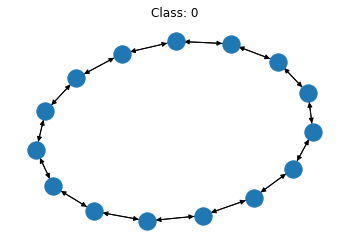

In [0]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [0]:
dataset.graphs 

[DGLGraph(num_nodes=15, num_edges=45,
          ndata_schemes={}
          edata_schemes={}), DGLGraph(num_nodes=10, num_edges=30,
          ndata_schemes={}
          edata_schemes={}), DGLGraph(num_nodes=16, num_edges=48,
          ndata_schemes={}
          edata_schemes={}), DGLGraph(num_nodes=15, num_edges=45,
          ndata_schemes={}
          edata_schemes={}), DGLGraph(num_nodes=19, num_edges=57,
          ndata_schemes={}
          edata_schemes={}), DGLGraph(num_nodes=19, num_edges=57,
          ndata_schemes={}
          edata_schemes={}), DGLGraph(num_nodes=12, num_edges=36,
          ndata_schemes={}
          edata_schemes={}), DGLGraph(num_nodes=10, num_edges=30,
          ndata_schemes={}
          edata_schemes={}), DGLGraph(num_nodes=13, num_edges=39,
          ndata_schemes={}
          edata_schemes={}), DGLGraph(num_nodes=11, num_edges=33,
          ndata_schemes={}
          edata_schemes={}), DGLGraph(num_nodes=17, num_edges=49,
          ndata_schemes={}
     

In [0]:
dataset.max_num_v, dataset.num_classes

(20, 8)

In [0]:
class_names ={   
   0 : 'cycle graph',
   1 : 'star graph',
   2 : 'wheel graph',
   3 : 'lollipop graph',
   4 : 'hypercube graph',
   5 : 'grid graph',
   6 : 'clique graph',
   7 : 'circular ladder graph',
}

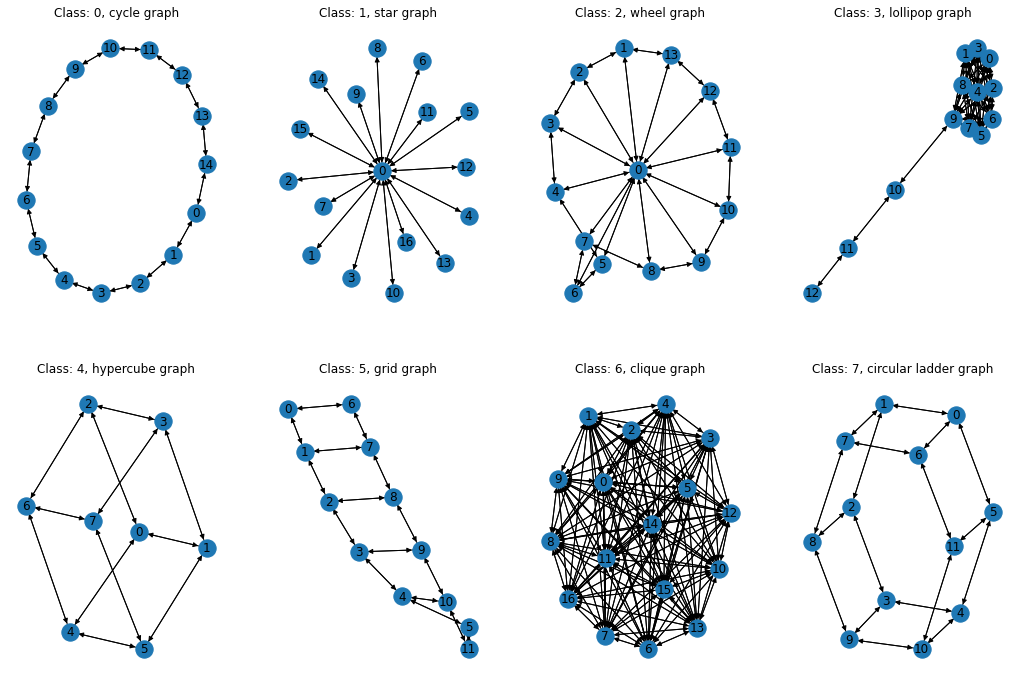

In [0]:
plt.rcParams["figure.figsize"]=18,12
fig, axes = plt.subplots(nrows=2, ncols=4)

iter = 0
for ax in axes.flatten() : 
    
    graph, label = dataset[10 * iter]
    
    nx.draw(graph.to_networkx(), with_labels=True, ax=ax)
    
    ax.set_title('Class: {:d}'.format(label) +', '+class_names[label] )
    
    iter += 1
  
plt.show()

# Forming a graph minibatch

## In general different elements of a batch can have different shapes (slide)

In [0]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

# Readout & Classification
###For this demonstration, consider initial node features to be their degrees. After two rounds of graph convolution, perform a graph readout by averaging over all node features for each graph in the batch. <br> $h_g = \frac{1}{\mathcal{|N|}} \sum_{\nu \in \mathcal{N}} h_{\nu} $

In [0]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
trainset = MiniGCDataset(1000, 10, 20)
testset = MiniGCDataset(300, 10, 20)
validset = MiniGCDataset(200, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

val_data_loader = DataLoader(validset, batch_size=42, shuffle=True,
                         collate_fn=collate)

test_data_loader = DataLoader(testset, batch_size=42, shuffle=True,
                         collate_fn=collate)

# Create model
model = Classifier(1, 256, trainset.num_classes)
#model = model.cuda()

# if torch.cuda.is_available():
#     model = model.cuda()


loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:
model

Classifier(
  (conv1): GraphConv(in=1, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (classify): Linear(in_features=256, out_features=8, bias=True)
)

In [0]:
## --------- Run the training loop ------------------- ##

n_epoch = 200

epoch_losses, epoch_val_losses = [], []
for epoch in range(1, n_epoch+1):
    epoch_loss = 0
    iter_batch = 0
    model.train()
    for bg, label in data_loader:

        # if torch.cuda.is_available():
        #    bg = bg.cuda()
        #    label = label.cuda()

        prediction = model(bg)
        
        loss = loss_func(prediction, label )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        iter_batch += 1
    epoch_loss /= (iter_batch + 1)
    #print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)
    
    
    epoch_val_loss = 0
    iter_batch_val = 0
    model.eval()
    for bg, label in val_data_loader:
            
        prediction = model(bg)
        loss = loss_func(prediction, label )
        epoch_val_loss += loss.detach().item()
        iter_batch_val += 1
    epoch_val_loss /= (iter_batch_val + 1)
    #print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_val_losses.append(epoch_val_loss)
    
    print('Epoch {}, loss {:.4f}, val_loss {:.4f}'.format(epoch, epoch_loss, epoch_val_loss))

Epoch 1, loss 1.8863, val_loss 1.5935
Epoch 2, loss 1.8347, val_loss 1.5143
Epoch 3, loss 1.7248, val_loss 1.4033
Epoch 4, loss 1.5720, val_loss 1.2564
Epoch 5, loss 1.3947, val_loss 1.1064
Epoch 6, loss 1.2350, val_loss 1.0216
Epoch 7, loss 1.1064, val_loss 0.9042
Epoch 8, loss 1.0046, val_loss 0.8126
Epoch 9, loss 0.9319, val_loss 0.7793
Epoch 10, loss 0.8896, val_loss 0.7375
Epoch 11, loss 0.8723, val_loss 0.6978
Epoch 12, loss 0.8194, val_loss 0.7031
Epoch 13, loss 0.7990, val_loss 0.6912
Epoch 14, loss 0.7779, val_loss 0.6368
Epoch 15, loss 0.7633, val_loss 0.6447
Epoch 16, loss 0.7460, val_loss 0.6223
Epoch 17, loss 0.7352, val_loss 0.6099
Epoch 18, loss 0.7259, val_loss 0.6106
Epoch 19, loss 0.7082, val_loss 0.5962
Epoch 20, loss 0.6928, val_loss 0.5754
Epoch 21, loss 0.6841, val_loss 0.5639
Epoch 22, loss 0.6719, val_loss 0.5698
Epoch 23, loss 0.6658, val_loss 0.5477
Epoch 24, loss 0.6712, val_loss 0.5459
Epoch 25, loss 0.6530, val_loss 0.5478
Epoch 26, loss 0.6608, val_loss 0.

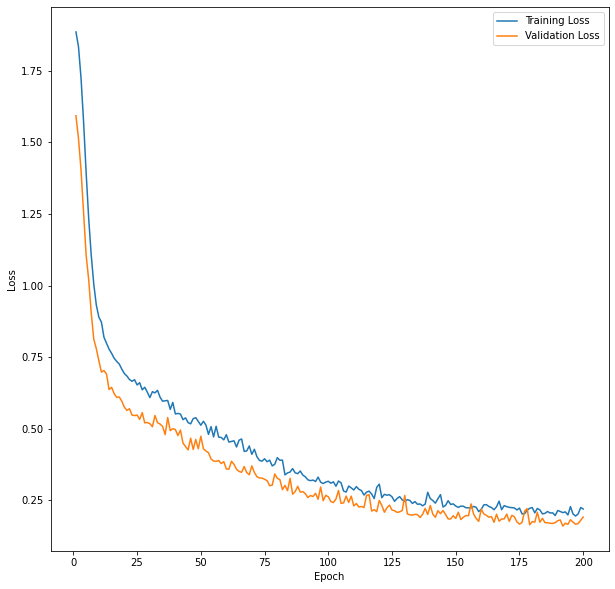

In [0]:
import numpy as np

plt.rcParams["figure.figsize"]=10,10

plt.plot( range(1, n_epoch+1), np.array(epoch_losses), label='Training Loss' )
plt.plot( range(1, n_epoch+1), np.array(epoch_val_losses), label='Validation Loss' )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y.cpu() , 1)
argmax_Y = torch.max(probs_Y.cpu(), 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
# print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
#     (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 84.6667%
